# 09_03: Evaluating model fit

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

In [2]:
import statsmodels
import statsmodels.formula.api as smf

In [3]:
gm = pd.read_csv('gapminder.csv', dtype_backend='pyarrow')

gdata = gm[gm.year == 1985].copy()
gdata['region'] = gdata['region'].astype('category')

In [4]:
continent = gdata.region.map({'Africa': 'skyblue', 'Europe': 'gold', 'America': 'palegreen', 'Asia': 'coral', 'Oceania': 'teal'})
population = 1e-6 * gdata.population

def plotbabies():
    gdata.plot.scatter('age5_surviving', 'babies_per_woman', c=continent, s=population,
                       linewidths=0.5, edgecolor='black', alpha=0.6, figsize=(5,3.5))

# define a function to plot residuals
def plotresidual(fit):
    pp.scatter(gdata.age5_surviving, fit.predict(gdata), color=continent, s=50, marker='.', ec='k', lw=0.5);

In [5]:
groupfit = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit()
survivingfit = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=gdata).fit()
twovariablefit = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region + population', data=gdata).fit()

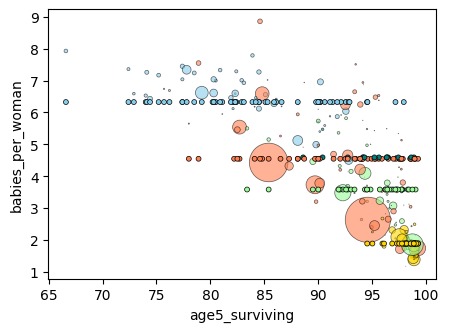

In [6]:
plotbabies()
plotresidual(groupfit)

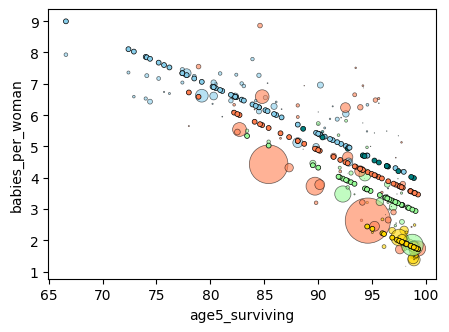

In [7]:
plotbabies()
plotresidual(survivingfit)

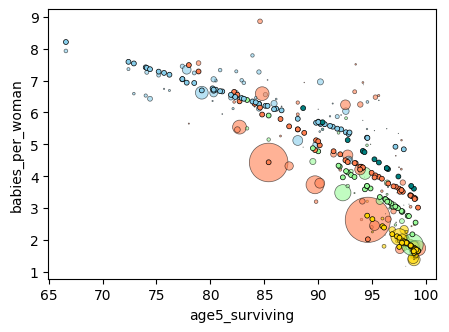

In [8]:
plotbabies()
plotresidual(twovariablefit)

In [9]:
gdata.babies_per_woman - survivingfit.predict(gdata)

169      0.964485
393       0.76746
617      1.027615
828     -0.398828
1052     0.111648
           ...   
40930    0.450375
41153   -0.077165
41351    3.149024
41575    0.466187
41783    0.734873
Length: 195, dtype: double[pyarrow]

In [10]:
survivingfit.resid

169      0.964485
393      0.767460
617      1.027615
828     -0.398828
1052     0.111648
           ...   
40930    0.450375
41153   -0.077165
41351    3.149024
41575    0.466187
41783    0.734873
Length: 195, dtype: float64

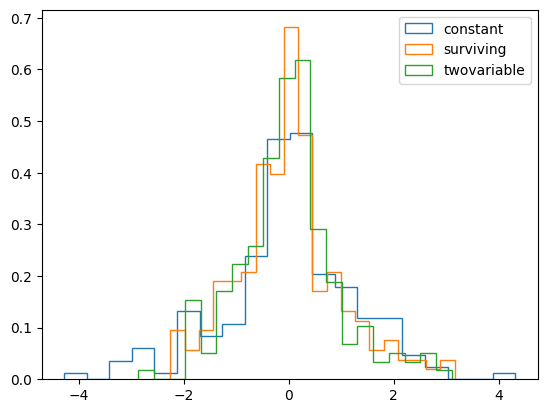

In [11]:
pp.hist(groupfit.resid, histtype='step', density=True, bins=20, label='constant')
pp.hist(survivingfit.resid, histtype='step', density=True, bins=20, label='surviving')
pp.hist(twovariablefit.resid, histtype='step', density=True, bins=20, label='twovariable')
pp.legend();

In [12]:
[fit.mse_resid for fit in [groupfit, survivingfit, twovariablefit]]

[np.float64(1.6102173625174048),
 np.float64(1.0148569308436735),
 np.float64(0.930809344988931)]

In [13]:
[fit.rsquared for fit in [groupfit, survivingfit, twovariablefit]]

[np.float64(0.6150742846880249),
 np.float64(0.7586732603637679),
 np.float64(0.7845148347657792)]

In [14]:
[fit.fvalue for fit in [groupfit, survivingfit, twovariablefit]]

[np.float64(75.90043314981475),
 np.float64(118.83411380346192),
 np.float64(66.98870868442471)]

In [15]:
twovariablefit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       babies_per_woman   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     66.99
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           6.02e-56
Time:                        17:28:13   Log-Likelihood:                -264.04
No. Observations:                 195   AIC:                             550.1
Df Residuals:                     184   BIC:                             586.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
region[Africa]                    15.4144      1.583      9.735      0.000      12.290      18.539
region[America]                   26.7269      4.362      6.127      0.000      18.121      35.333
region[Asia]                      23.0048      2.228     10.327      0.000      18.610      27.400
region[Europe]                    24.8203     13.614      1.823      0.070      -2.039      51.680
region[Oceania]                   27.6798      8.762      3.159      0.002      10.393      44.967
age5_surviving:region[Africa]     -0.1079      0.019     -5.746      0.000      -0.145      -0.071
age5_surviving:region[America]    -0.2437      0.046     -5.301      0.000      -0.334      -0.153
age5_surviving:region[Asia]       -0.1989      0.024     -8.261      0.000      -0.246      -0.151
age5_surviving:region[Europe]     -0.2333      0.139     -1.682      0.094      -0.507       0.040
age5_surviving:region[Oceania]    -0.2432      0.092     -2.636      0.009      -0.425      -0.061
population                     -2.044e-09   7.31e-10     -2.797      0.006   -3.49e-09   -6.02e-10
==============================================================================
Omnibus:                       11.488   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.230
Skew:                           0.401   Prob(JB):                     0.000493
Kurtosis:                       4.110   Cond. No.                     1.97e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
shuffled = gdata.sample(len(gdata))

In [17]:
ntrain = int(0.9 * len(gdata))
training, testing = shuffled.iloc[:ntrain], shuffled.iloc[ntrain:]

In [18]:
len(training), len(testing)

(175, 20)

In [19]:
grouptrain = smf.ols(formula='babies_per_woman ~ -1 + region', data=training).fit()
survivingtrain = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=training).fit()
twovariabletrain = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region + population', data=training).fit()

In [20]:
grouptrain.params

region[Africa]     6.340851
region[America]    3.656250
region[Asia]       4.711364
region[Europe]     1.888205
region[Oceania]    4.623846
dtype: float64

In [21]:
groupfit.params

region[Africa]     6.326296
region[America]    3.581143
region[Asia]       4.546400
region[Europe]     1.885476
region[Oceania]    4.589286
dtype: float64

In [22]:
def mse_test(fit, testing):
    return np.sum((fit.predict(testing) - testing.babies_per_woman)**2) / (len(testing) - len(fit.params))

In [23]:
[mse_test(fit, testing) for fit in [grouptrain, survivingtrain, twovariabletrain]] # testing MSE

[2.6671963198396478, 1.4614363660822398, 2.277946436046061]

In [24]:
mses = []
for i in range(100):
    shuffled = gdata.sample(len(gdata))
    training, testing = shuffled.iloc[:ntrain], shuffled.iloc[ntrain:]
    mses.append([mse_test(fit, testing) for fit in [grouptrain, survivingtrain, twovariabletrain]])

print(np.array(mses).mean(axis=0))

[2.00723179 1.36749473 1.87937937]
